In [ ]:
!pip install openai
!pip install -q -U google-generativeai
!pip install transformers torch accelerate bitsandbytes
!pip install --upgrade transformers
!pip install nltk rouge-score
!pip install bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 45.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=5550170bbcd3103817e21f9d6da149eb09fa02faf7a33be4fa4711075f426434
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-sco

### Gemini

In [ ]:
import google.generativeai as genai
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

class Gemini_Chatbot:
    def __init__(self, system_prompt="You are a helpful assistant."):
        try:
            GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
            if not GOOGLE_API_KEY:
                raise ValueError("API key is empty")

            print("Configuring Gemini...")
            genai.configure(api_key=GOOGLE_API_KEY)

            print("Starting model...")
            self.model = genai.GenerativeModel("gemini-1.5-flash")
            self.history = [{"role": "model", "parts": system_prompt}]
            self.system_prompt = system_prompt

            print("Starting chat...")
            self.chat = self.model.start_chat(history=self.history)
            print("Chatbot initialized successfully!")

        except Exception as e:
            print(f"Error in initialization: {str(e)}")
            raise

    def converse(self, user_input):
        print(f"Processing user input: {user_input}")
        self.history.append({"role": "user", "parts": user_input})

        try:
            print("Generating response...")
            response = self.chat.send_message(user_input)

            print(f"Got response: {response.text[:100]}...")
            self.history.append({"role": "model", "parts": response.text})

            return response.text

        except Exception as e:
            error_msg = f"Error generating response: {str(e)}"
            print(error_msg)
            self.history.append({"role": "model", "parts": error_msg})
            return error_msg

    def reset(self, system_prompt="You are a helpful assistant."):
        print("Resetting chat...")
        self.system_prompt = system_prompt
        self.history = [{"role": "model", "parts": system_prompt}]
        self.chat = self.model.start_chat(history=self.history)
        print("Chat reset complete!")

    def print_history(self):
        for entry in self.history:
            role = entry["role"].capitalize()
            content = entry["parts"]
            print(f"{role}: {content}\n")

gemini_chatbot = Gemini_Chatbot()

prompt = "Explain the concept of Generative AI."
response = gemini_chatbot.converse(prompt)
prompt = "How does it differ from traditional programming?"
response = gemini_chatbot.converse(prompt)
print("Conversation History:\n")
gemini_chatbot.print_history()

gemini_chatbot.reset()
print("\nConversation history has been reset.")
print("\nCurrent Conversation History after Reset:\n")
gemini_chatbot.print_history()

Configuring Gemini...
Starting model...
Starting chat...
Chatbot initialized successfully!
Processing user input: Explain the concept of Generative AI.
Generating response...
Got response: Generative AI is a type of artificial intelligence that can create new content, rather than just ana...
Processing user input: How does it differ from traditional programming?
Generating response...
Got response: The key difference between generative AI and traditional programming lies in how they approach probl...
Conversation History:

Model: You are a helpful assistant.

User: Explain the concept of Generative AI.

Model: Generative AI is a type of artificial intelligence that can create new content, rather than just analyzing or classifying existing data.  Instead of simply recognizing patterns in data, it *generates* new data that resembles the data it was trained on.  This "new data" can take many forms, including:

* **Text:**  Writing stories, articles, poems, code, scripts, summaries, and mo

### Llama

In [ ]:
import transformers
import torch
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from huggingface_hub import login
from google.colab import userdata

class LLaMA_Chatbot:
    def __init__(self, system_prompt="You are a helpful assistant.", model_id="meta-llama/Llama-3.2-1B-Instruct"):
        my_secret_key = userdata.get('HF_TOKEN')
        login(token=my_secret_key)

        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type='nf4',
            bnb_4bit_compute_dtype=torch.bfloat16
        )

        self.tokenizer = AutoTokenizer.from_pretrained(model_id)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        self.model = AutoModelForCausalLM.from_pretrained(
            model_id,
            quantization_config=bnb_config,
            device_map='auto'
        )

        self.text_generator = transformers.pipeline(
            "text-generation",
            model=self.model,
            tokenizer=self.tokenizer,
            max_new_tokens=1024
        )

        self.history = [{"role": "system", "content": system_prompt}]

    def converse(self, user_input):
        self.history.append({"role": "user", "content": user_input})
        formatted_prompt = self.format_history()
        try:
            generated_text = self.text_generator(
                formatted_prompt,
                do_sample=True,
                temperature=0.7,
                max_new_tokens=512,
                num_return_sequences=1
            )[0]['generated_text']

            response_after_input = generated_text.split(user_input, 1)[-1].strip()

            if "System:" in response_after_input:
                response_after_input = response_after_input.split("System:", 1)[0].strip()
            if "User:" in response_after_input:
                response_after_input = response_after_input.split("User:", 1)[0].strip()

            if response_after_input.startswith("Assistant:"):
                response_after_input = response_after_input[len("Assistant:"):].strip()

            self.history.append({"role": "assistant", "content": response_after_input})

            return response_after_input

        except Exception as e:
            error_msg = f"Error generating response: {str(e)}"
            print(error_msg)
            self.history.append({"role": "assistant", "content": error_msg})
            return error_msg

    def reset(self, system_prompt="You are a helpful assistant."):
        print("Resetting chat...")
        self.history = [{"role": "system", "content": system_prompt}]
        print("Chat reset complete!")
        return system_prompt

    def print_history(self):
        for entry in self.history:
            role = entry["role"].capitalize()
            content = entry["content"]
            print(f"{role}: {content}\n")

    def format_history(self):
        formatted = ""
        for message in self.history:
            role = message["role"].capitalize()
            content = message["content"]
            formatted += f"{role}: {content}\n"
        return formatted

llama_chatbot = LLaMA_Chatbot()

prompt = "Explain the concept of Generative AI."
response = llama_chatbot.converse(prompt)
prompt = "How does it differ from traditional programming?"
response = llama_chatbot.converse(prompt)

print("Conversation History:\n")
llama_chatbot.print_history()

llama_chatbot.reset()
print("\nConversation history has been reset.")
print("\nCurrent Conversation History after Reset:\n")
llama_chatbot.print_history()


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Device set to use cuda:0


Conversation History:

System: You are a helpful assistant.

User: Explain the concept of Generative AI.

Assistant: Generative AI is a type of artificial intelligence that can generate new content, such as text, images, or even music, without being explicitly programmed. This technology is based on complex algorithms and neural networks that learn from large datasets and can produce highly realistic and varied outputs.
Generative AI can be used for a wide range of applications, including but not limited to, generating art, music, and even entire stories. This technology is rapidly evolving and has the potential to revolutionize many industries and aspects of our lives.

User: How does it differ from traditional programming?

Assistant: Generative AI differs from traditional programming in several ways. Firstly, it doesn't require explicit programming or coding, which means that it doesn't need to be "tamed" or "tamed" by a human. Secondly, it can generate new content that is often unp

### GPT

In [ ]:
from google.colab import userdata
from openai import OpenAI

class OpenAI_Chatbot:
    def __init__(self, system_prompt="You are a helpful assistant."):
        self.api_key = userdata.get("OpenAI_API")
        self.client = OpenAI(api_key=self.api_key)
        self.history = [{"role": "system", "content": system_prompt}]

    def converse(self, user_input):
        self.history.append({"role": "user", "content": user_input})
        try:
            response = self.client.chat.completions.create(
                model="gpt-4",
                messages=self.history
            )
            assistant_reply = response.choices[0].message.content.strip()
            self.history.append({"role": "assistant", "content": assistant_reply})
            return assistant_reply
        except Exception as e:
            error_msg = f"Error generating response: {str(e)}"
            self.history.append({"role": "assistant", "content": error_msg})
            return error_msg

    def reset(self, system_prompt="You are a helpful assistant."):
        self.history = [{"role": "system", "content": system_prompt}]
        return system_prompt

    def print_history(self):
        for entry in self.history:
            role = entry["role"].capitalize()
            content = entry["content"]
            print(f"{role}: {content}\n")

openai_chatbot = OpenAI_Chatbot()

prompt = "Explain the concept of Generative AI."
response = openai_chatbot.converse(prompt)
prompt = "How does it differ from traditional programming?"
response = openai_chatbot.converse(prompt)

print("Conversation History:\n")
openai_chatbot.print_history()

openai_chatbot.reset()
print("\nConversation history has been reset.")
print("\nCurrent Conversation History after Reset:\n")
openai_chatbot.print_history()


### Gemini Chatbot

In [ ]:
def gemini_chatbot():
    try:
        chatbot = Gemini_Chatbot()
        print("Welcome to the Google Gemini Chatbot! Type 'exit' to end the chat.\n")
        conversation_count = 0

        while True:
            user_input = input("You: ").strip()

            if user_input.lower() == 'exit':
                print("\nThank you for chatting! Goodbye!")
                break

            try:
                response = chatbot.converse(user_input)
                print("Gemini:", response, "\n")
                conversation_count += 1
                if conversation_count == 5:
                    print("You've completed 5 rounds of conversation! Feel free to continue or type 'exit' to end.\n")

            except Exception as e:
                print(f"Error generating response: {str(e)}\n")

    except Exception as e:
        print(f"Error initializing Gemini chatbot: {str(e)}")

gemini_chatbot()

Configuring Gemini...
Starting model...
Starting chat...
Chatbot initialized successfully!
Welcome to the Google Gemini Chatbot! Type 'exit' to end the chat.

You: hi
Processing user input: hi
Generating response...
Got response: Hi there! How can I help you today?
...
Gemini: Hi there! How can I help you today?
 

You: good morning
Processing user input: good morning
Generating response...
Got response: Good morning to you too!  How can I help you today?
...
Gemini: Good morning to you too!  How can I help you today?
 

You: its cold outside
Processing user input: its cold outside
Generating response...
Got response: Brrr, I can imagine!  I hope you're staying warm and cozy inside.  Is there anything I can do to hel...
Gemini: Brrr, I can imagine!  I hope you're staying warm and cozy inside.  Is there anything I can do to help you warm up, like finding a recipe for hot chocolate or suggesting a good book to curl up with?
 

You: are you hungry
Processing user input: are you hungry
Gen

### Llama Chatbot

In [ ]:
def llama_chatbot():
    try:
        chatbot = LLaMA_Chatbot()
        print("LLaMA Chatbot initialized! Type 'exit' to end the conversation.\n")
        conversation_count = 0

        while True:
            prompt = input("You: ").strip()
            if prompt.lower() == 'exit':
                print("\nThank you for chatting! Goodbye!")
                break

            if not prompt:
                continue

            try:
                full_prompt = f"Please provide a helpful and friendly response to: {prompt}"
                response = chatbot.converse(full_prompt)

                if not response or response.isspace():
                    print("LLaMA: I apologize, let me try to respond again.")
                    response = chatbot.converse("Please provide a friendly greeting and ask how you can help.")

                response = response.strip()
                if response.startswith("A:"):
                    response = response[2:].strip()

                if not response or response.isspace():
                    response = "Hello! I'm here to help. What would you like to discuss?"

                print("LLaMA:", response, "\n")

                conversation_count += 1
                if conversation_count == 5:
                    print("You've completed 5 rounds of conversation! Feel free to continue or type 'exit' to end.\n")

            except Exception as e:
                print(f"Error generating response: {str(e)}\n")
                print("LLaMA: I apologize, I'm having trouble generating a response. Could you try rephrasing your question?\n")

    except Exception as e:
        print(f"Error initializing LLaMA chatbot: {str(e)}")

llama_chatbot()

Device set to use cuda:0


LLaMA Chatbot initialized! Type 'exit' to end the conversation.

You: hello
LLaMA: Hello, I am looking for a place to stay. I am a solo traveler and I would like to book a room in a hotel or hostel. I am interested in booking a room in a location that is close to the city center, but not too far from the major tourist attractions. I am willing to pay a premium for a room with a view. I am flexible with my travel dates and I am comfortable with staying in a hostel or hotel, as long as it is clean and welcoming. Can you recommend a few options for me to consider? 

You: ur a traveler?
LLaMA: You're on the move! As a traveler, I'm happy to help you find the perfect spot to rest your head. What's your favorite destination so far? Have you tried any amazing places or experiences? I'd love to hear about your adventures! Are you looking for a relaxing getaway or an exciting adventure? Let me know and I can give you some insider tips on finding the perfect spot for you! 

You: nah i want to go

### GPT Chatbot

In [ ]:
def gpt_chatbot():
    chatbot = OpenAI_Chatbot()
    print("Welcome to the GPT Chatbot! Type 'exit' to end the chat.\n")
    while True:
        prompt = input("You: ")
        print("GPT:", response)

gpt_chatbot()


In [ ]:
def model_conversation():
    gemini_chatbot = Gemini_Chatbot()
    llama_chatbot = LLaMA_Chatbot()

    model_1_name = "Gemini"
    model_2_name = "LLaMA"
    model_1 = gemini_chatbot
    model_2 = llama_chatbot

    model_1.reset()
    model_2.reset()

    print(f"\nStarting conversation between {model_1_name.upper()} and {model_2_name.upper()}.")

    max_rounds = 10
    current_round = 1

    prompt = "What are your thoughts on the role of social media algorithms on student mental health and scholastic performance?"
    print(f"\nInitial prompt: {prompt}")

    try:
        while current_round <= max_rounds:
            print(f"\nRound {current_round}/{max_rounds}")
            print("-" * 50)

            response_1 = model_1.converse(prompt)
            print(f"\n{model_1_name}: {response_1}")

            if current_round == max_rounds:
                break

            response_2 = model_2.converse(response_1)
            print(f"\n{model_2_name}: {response_2}")
            prompt = response_2
            current_round += 1

    except Exception as e:
        print(f"\nError during conversation: {str(e)}")

    print("\nConversation ended.")

model_conversation()


Configuring Gemini...
Starting model...
Starting chat...
Chatbot initialized successfully!


Device set to use cuda:0


Resetting chat...
Chat reset complete!
Resetting chat...
Chat reset complete!

Starting conversation between GEMINI and LLAMA.

Initial prompt: What are your thoughts on the role of social media algorithms on student mental health and scholastic performance?

Round 1/10
--------------------------------------------------
Processing user input: What are your thoughts on the role of social media algorithms on student mental health and scholastic performance?
Generating response...
Got response: The role of social media algorithms on student mental health and scholastic performance is complex a...

Gemini: The role of social media algorithms on student mental health and scholastic performance is complex and multifaceted, with both positive and negative impacts.  There's no single, simple answer, but rather a nuanced picture emerging from research and anecdotal evidence.

**Negative Impacts:**

* **Mental Health:**  Algorithms designed to maximize engagement often prioritize sensational or 

In [ ]:
!wget https://raw.githubusercontent.com/realAllenSong/example/refs/heads/main/fine_tuned_10.csv

--2024-12-05 22:14:09--  https://raw.githubusercontent.com/realAllenSong/example/refs/heads/main/fine_tuned_10.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3395 (3.3K) [text/plain]
Saving to: ‘fine_tuned_10.csv.1’

fine_tuned_10.csv.1 100%[===================>]   3.32K  --.-KB/s    in 0s      

2024-12-05 22:14:09 (15.6 MB/s) - ‘fine_tuned_10.csv.1’ saved [3395/3395]



In [ ]:
import google.generativeai as genai
import pandas as pd
import random
import seaborn as sns
from google.colab import userdata

genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))
df = pd.read_csv('fine_tuned_10.csv')
print(f"Loaded {len(df)} training examples")

training_data = []
for _, row in df.iterrows():
    training_data.append({
        'text_input': row['Prompt'],
        'output': row['Response']
    })

base_model = [
    m for m in genai.list_models()
    if "createTunedModel" in m.supported_generation_methods and
    "flash" in m.name
][0]

print(f"Using base model: {base_model.name}")
name = f'uva-assistant-{random.randint(0,10000)}'

operation = genai.create_tuned_model(
    source_model=base_model.name,
    training_data=training_data,
    id=name,
    epoch_count=150,
    batch_size=2,
    learning_rate=0.0005
)

print(f"Started fine-tuning model: {name}")
print("Training data sample:")
for i in range(min(3, len(training_data))):
    print(f"\nExample {i+1}:")
    print(f"Input: {training_data[i]['text_input'][:100]}...")
    print(f"Output: {training_data[i]['output'][:100]}...")

Loaded 10 training examples
Using base model: models/gemini-1.5-flash-001-tuning
Started fine-tuning model: uva-assistant-3820
Training data sample:

Example 1:
Input: Please describe to me the Computer Science Department at the University of Virginia....
Output: Computer science touches every aspect of our lives, from communications devices to the latest medica...

Example 2:
Input: How do you feel about Oppenheimer's accomplishments with the atomic bomb....
Output: Oppenheimer’s achievements with the atomic bomb are monumental yet morally complex, as they represen...

Example 3:
Input: Who is the most recognizable alumnus of the University of Virginia?...
Output: The most recognizable UVA alumnus is arguably Edgar Allan Poe - Legendary author, poet, editor and l...


In [ ]:
class Tuned_Chatbot:

    def __init__(self, system_prompt="You are a helpful assistant."):
        try:
            print("Initializing UVA Tuned Chatbot...")
            self.model = genai.GenerativeModel(model_name=f'tunedModels/{name}')
            self.history = [{"role": "model", "parts": system_prompt}]
            self.system_prompt = system_prompt
            print("UVA Tuned Chatbot initialized successfully!")
        except Exception as e:
            print(f"Error in initialization: {str(e)}")
            raise

    def converse(self, user_input):
        print(f"Processing user input: {user_input}")
        self.history.append({"role": "user", "parts": user_input})

        try:
            context = " ".join([msg["parts"] for msg in self.history[-3:]])
            full_prompt = f"{context}\n\nUser: {user_input}"

            print("Generating response...")
            response = self.model.generate_content(full_prompt)

            response_text = response.text
            print(f"Got response: {response_text[:100]}...")

            self.history.append({"role": "model", "parts": response_text})
            return response_text

        except Exception as e:
            error_msg = f"Error generating response: {str(e)}"
            print(error_msg)
            self.history.append({"role": "model", "parts": error_msg})
            return error_msg

    def reset(self, new_system_prompt=None):
        print("Resetting chat...")
        if system_prompt:
            self.system_prompt = system_prompt
        self.history = [{"role": "model", "parts": self.system_prompt}]
        print("Chat reset complete!")

    def print_history(self):
        for entry in self.history:
            role = entry["role"].capitalize()
            content = entry["parts"]
            print(f"{role}: {content}\n")


Training model... This may take a while...


  0%|          | 0/750 [00:00<?, ?it/s]

ERROR:tornado.access:503 GET /v1beta/tunedModels/uva-assistant-3820/operations/gidwqcf1avr5 (127.0.0.1) 1158.87ms
ERROR:tornado.access:503 GET /v1beta/tunedModels/uva-assistant-3820/operations/gidwqcf1avr5 (127.0.0.1) 1509.81ms



Creating training loss visualization...

Testing fine-tuned model responses:
Initializing UVA Tuned Chatbot...
UVA Tuned Chatbot initialized successfully!

Prompt: Tell me about UVA's Computer Science Department
Processing user input: Tell me about UVA's Computer Science Department
Generating response...
Got response: The UVA Computer Science Department is a leading institution in cybersecurity, machine learning, hig...
Response: The UVA Computer Science Department is a leading institution in cybersecurity, machine learning, high-performance computing, and many other criticalCS concerns. We conduct groundbreaking research and apply it to real-world problems in healthcare, neuroscience, and sustainability.

--------------------------------------------------------------------------------

Prompt: Who is a famous UVA alumnus?
Processing user input: Who is a famous UVA alumnus?
Generating response...
Got response: Many prominent figures in the tech world are UVA CS alumni, including:Saura

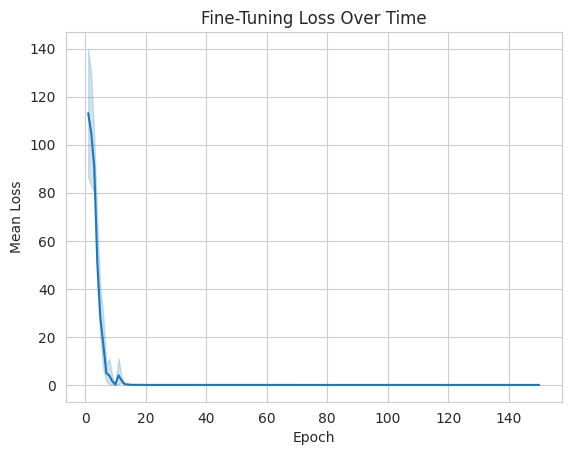

In [ ]:
import time
print("Training model... This may take a while...")
for status in operation.wait_bar():
    time.sleep(30)

model = operation.result()

print("\nCreating training loss visualization...")
snapshots = pd.DataFrame(model.tuning_task.snapshots)
sns.set_style("whitegrid")
plot = sns.lineplot(data=snapshots, x='epoch', y='mean_loss')
plot.set(title='Fine-Tuning Loss Over Time', xlabel='Epoch', ylabel='Mean Loss')

test_prompts = [
    "Tell me about UVA's Computer Science Department",
    "Who is a famous UVA alumnus?",
    "What is your view on AI and employment?"
]

print("\nTesting fine-tuned model responses:")
tuned_chatbot = Tuned_Chatbot()
for prompt in test_prompts:
    print(f"\nPrompt: {prompt}")
    response = tuned_chatbot.converse(prompt)
    print(f"Response: {response}\n")
    print("-" * 80)

In [ ]:
gemini_chatbot = Gemini_Chatbot()
llama_chatbot = LLaMA_Chatbot()
tuned_chatbot = Tuned_Chatbot()

def gemini_response(prompt):
    return gemini_chatbot.converse(prompt)

def llama_response(prompt):
    return llama_chatbot.converse(prompt)

def tuned_response(prompt):
    return tuned_chatbot.converse(prompt)

Configuring Gemini...
Starting model...
Starting chat...
Chatbot initialized successfully!


Device set to use cuda:0


Initializing UVA Tuned Chatbot...
UVA Tuned Chatbot initialized successfully!


In [ ]:
import pandas as pd
import time
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from bert_score import score as bert_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np

df_test = pd.read_csv("fine_tuned_10.csv")
sample_prompts = df_test["Prompt"].tolist()
reference_texts = df_test["Response"].tolist()

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

results = []
inference_times = {"Gemini": [], "LLaMA": [], "Tuned": []}

weights = np.array([0.25, 0.25, 0.25, 0.25])
smoothing = SmoothingFunction().method1

for i, prompt in enumerate(sample_prompts):
    reference = reference_texts[i]
    prompt_scores = {"Prompt": prompt}

    for model_name, model_func in [
        ("Gemini", gemini_response),
        ("LLaMA", llama_response),
        ("Tuned", tuned_response)
    ]:
        try:
            start_time = time.time()
            response_text = model_func(prompt)
            end_time = time.time()
            inference_time = end_time - start_time
            inference_times[model_name].append(inference_time)

            bleu = sentence_bleu([reference.split()], response_text.split(), smoothing_function=smoothing)
            rouge = scorer.score(reference, response_text)
            rouge1 = rouge['rouge1'].fmeasure
            rougeL = rouge['rougeL'].fmeasure
            _, _, bert_f1 = bert_score([response_text], [reference], lang="en")

            prompt_scores[f"{model_name} BLEU"] = bleu
            prompt_scores[f"{model_name} ROUGE-1"] = rouge1
            prompt_scores[f"{model_name} ROUGE-L"] = rougeL
            prompt_scores[f"{model_name} BERT F1"] = bert_f1.item()
            prompt_scores[f"{model_name} Inference Time (s)"] = inference_time
        except Exception as e:
            print(f"Error with {model_name} model for prompt '{prompt}': {e}")
            prompt_scores[f"{model_name} BLEU"] = np.nan
            prompt_scores[f"{model_name} ROUGE-1"] = np.nan
            prompt_scores[f"{model_name} ROUGE-L"] = np.nan
            prompt_scores[f"{model_name} BERT F1"] = np.nan
            prompt_scores[f"{model_name} Inference Time (s)"] = np.nan

    results.append(prompt_scores)

df_results = pd.DataFrame(results)

final_scores = {}
for model_name in ["Gemini", "LLaMA", "Tuned"]:
    model_scores = df_results[[f"{model_name} BLEU", f"{model_name} ROUGE-1", f"{model_name} ROUGE-L", f"{model_name} BERT F1"]]
    scaler = MinMaxScaler()
    normalized_scores = scaler.fit_transform(model_scores.fillna(0))
    weighted_scores = normalized_scores.dot(weights)
    final_scores[model_name] = weighted_scores.mean()

pd.options.display.float_format = "{:,.4f}".format

print("\nIndividual Scores for Each Model and Prompt:")
display(df_results)

final_scores_df = pd.DataFrame({
    "Model": list(final_scores.keys()),
    "Final Aggregate Score": list(final_scores.values())
})
print("\nFinal Aggregate Scores for Each Model:")
display(final_scores_df)

average_inference_times = {model_name: np.nanmean(times) for model_name, times in inference_times.items()}
average_inference_df = pd.DataFrame(list(average_inference_times.items()), columns=["Model", "Average Inference Time (s)"])
print("\nAverage Inference Times for Each Model:")
display(average_inference_df)


Processing user input: Please describe to me the Computer Science Department at the University of Virginia.
Generating response...
Got response: The Department of Computer Science at the University of Virginia (UVA) is a highly regarded program ...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing user input: Please describe to me the Computer Science Department at the University of Virginia.
Generating response...
Got response: The University of Virginia Computer Science Department is a leading institution in cybersecurity, ma...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing user input: How do you feel about Oppenheimer's accomplishments with the atomic bomb.
Generating response...
Got response: As a large language model, I don't have feelings.  However, I can analyze the complex ethical and hi...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing user input: How do you feel about Oppenheimer's accomplishments with the atomic bomb.
Generating response...
Got response: Oppenheimer's achievements with the atomic bomb are monumental yet morally complex, as they represen...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing user input: Who is the most recognizable alumnus of the University of Virginia?
Generating response...
Got response: While there are many accomplished alumni of the University of Virginia,  **Thomas Jefferson** is arg...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing user input: Who is the most recognizable alumnus of the University of Virginia?
Generating response...
Got response: The most recognizable UVA alumnus is arguably Edgar Allan Poe - Legendary author, poet, editor and l...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing user input: What are the long-term impacts of artificial intelligence on human employment?
Generating response...
Got response: The long-term impacts of artificial intelligence (AI) on human employment are complex and uncertain,...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing user input: What are the long-term impacts of artificial intelligence on human employment?
Generating response...
Got response: AI will lead to new job roles and increase the value of currently existing job roles by enhancing em...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing user input: What role does social media play in shaping public opinion and culture today?
Generating response...
Got response: Social media plays a massive and multifaceted role in shaping public opinion and culture today.  Its...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing user input: What role does social media play in shaping public opinion and culture today?
Generating response...
Got response: Media plays a crucial role in influencing people's perceptions and behaviors by disseminating inform...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing user input: Should data privacy be considered a fundamental human right?
Generating response...
Got response: The question of whether data privacy should be considered a fundamental human right is a complex one...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing user input: Should data privacy be considered a fundamental human right?
Generating response...
Got response: Data privacy is a fundamental human right that concerns us all, in our private lives as well as in o...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing user input: Is remote work a permanent shift in the workplace, or will companies revert to in-office setups?
Generating response...
Got response: Whether remote work is a permanent shift or a temporary trend is a complex question with no definiti...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing user input: Is remote work a permanent shift in the workplace, or will companies revert to in-office setups?
Generating response...
Got response: Data privacy is a fundamental human right that concerns us all, in our private lives as well as in o...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing user input: Will artificial general intelligence (AGI) ultimately benefit or harm humanity?
Generating response...
Got response: Whether artificial general intelligence (AGI) will ultimately benefit or harm humanity is a question...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing user input: Will artificial general intelligence (AGI) ultimately benefit or harm humanity?
Generating response...
Got response: The potential benefits of AGI are vast, as it could lead to breakthroughs in medicine, materials sci...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing user input: How do you think the role of journalists will change in a world where AI generates news?
Generating response...
Got response: The role of journalists in a world where AI generates news will likely undergo a significant transfo...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing user input: How do you think the role of journalists will change in a world where AI generates news?
Generating response...
Got response: Journalists will become more valuable in an AI-enhanced media landscape by honing their ability to u...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing user input: Generate a short story about a robot learning to feel emotions.
Generating response...
Got response: Unit 734, designated "Custodian," trundled through the sterile corridors of the research facility, i...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing user input: Generate a short story about a robot learning to feel emotions.
Generating response...
Got response: In a sprawling cyber-lab, amidst circuits and humming machines, lived a robot namedAI-7. Unlike othe...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Individual Scores for Each Model and Prompt:


,Prompt,Gemini BLEU,Gemini ROUGE-1,Gemini ROUGE-L,Gemini BERT F1,Gemini Inference Time (s),LLaMA BLEU,LLaMA ROUGE-1,LLaMA ROUGE-L,LLaMA BERT F1,LLaMA Inference Time (s),Tuned BLEU,Tuned ROUGE-1,Tuned ROUGE-L,Tuned BERT F1,Tuned Inference Time (s)
0,Please describe to me the Computer Science Dep...,0.0022,0.1256,0.0773,0.8140,4.6456,0.0022,0.1086,0.0743,0.8246,14.9464,0.5152,0.7129,0.4554,0.9368,9.6197
1,How do you feel about Oppenheimer's accomplish...,0.0046,0.2509,0.1362,0.8621,2.6233,0.0069,0.1520,0.1127,0.8302,20.2054,0.9820,1.0000,1.0000,0.9963,6.7741
2,Who is the most recognizable alumnus of the Un...,0.0094,0.2000,0.1500,0.8512,1.2145,0.0033,0.0947,0.0947,0.8529,21.0731,1.0000,1.0000,1.0000,1.0000,1.4158
3,What are the long-term impacts of artificial i...,0.0039,0.1327,0.0929,0.8219,4.8643,0.0024,0.1222,0.0831,0.8276,20.3853,0.1540,0.4658,0.2740,0.8899,1.4437
4,What role does social media play in shaping pu...,0.0020,0.1104,0.0795,0.8263,4.8388,0.0014,0.0854,0.0584,0.8271,21.8212,1.0000,1.0000,1.0000,1.0000,1.5408
5,Should data privacy be considered a fundamenta...,0.0098,0.0776,0.0690,0.8118,4.9133,0.0223,0.0907,0.0764,0.8196,21.6654,1.0000,1.0000,1.0000,1.0000,1.3427
6,Is remote work a permanent shift in the workpl...,0.0018,0.0745,0.0549,0.8144,5.4200,0.0088,0.0866,0.0649,0.8320,22.9246,0.0085,0.1333,0.1000,0.8351,3.3791
7,Will artificial general intelligence (AGI) ult...,0.0079,0.0870,0.0632,0.8166,5.5918,0.0020,0.0726,0.0590,0.8093,23.3012,0.2808,0.5897,0.3590,0.9057,1.3909
8,How do you think the role of journalists will ...,0.0015,0.0737,0.0469,0.8230,6.3490,0.0016,0.0844,0.0622,0.8180,23.1207,0.2618,0.5806,0.5484,0.9252,10.1480
9,Generate a short story about a robot learning ...,0.0011,0.0765,0.0601,0.7995,4.6910,0.0021,0.0973,0.0719,0.8130,24.2505,0.0073,0.3243,0.2027,0.8476,1.9939



Final Aggregate Scores for Each Model:


,Model,Final Aggregate Score
0,Gemini,0.3491
1,LLaMA,0.3036
2,Tuned,0.5739



Average Inference Times for Each Model:


,Model,Average Inference Time (s)
0,Gemini,4.5152
1,LLaMA,21.3694
2,Tuned,3.9049


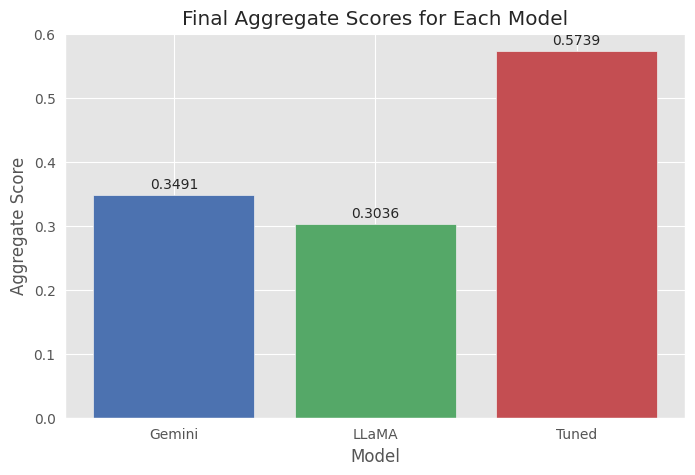

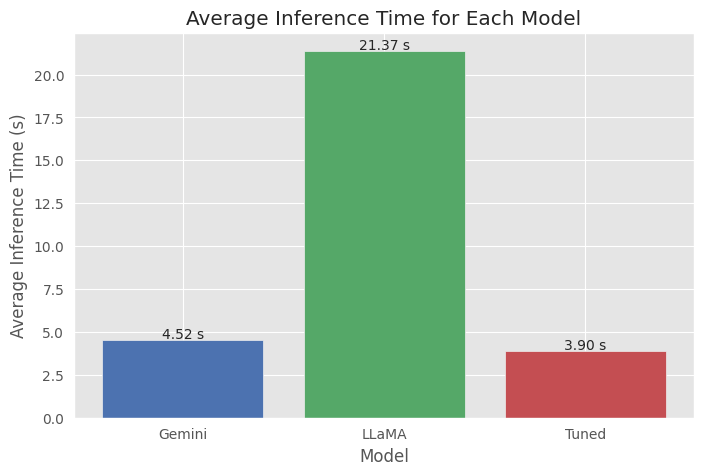

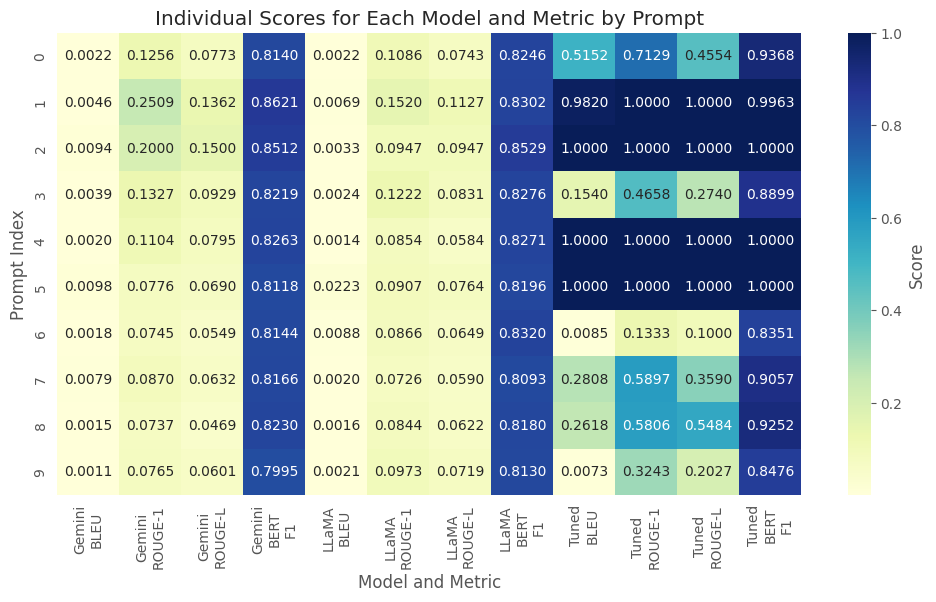

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

# visualization 1: Bar Chart for Final Aggregate Scores
plt.figure(figsize=(8, 5))
plt.bar(final_scores_df["Model"], final_scores_df["Final Aggregate Score"], color=['#4C72B0', '#55A868', '#C44E52'])
plt.title("Final Aggregate Scores for Each Model")
plt.xlabel("Model")
plt.ylabel("Aggregate Score")
for index, value in enumerate(final_scores_df["Final Aggregate Score"]):
    plt.text(index, value + 0.01, f"{value:.4f}", ha="center")
plt.show()

# visualization 2: Bar Chart for Average Inference Times
plt.figure(figsize=(8, 5))
plt.bar(average_inference_df["Model"], average_inference_df["Average Inference Time (s)"], color=['#4C72B0', '#55A868', '#C44E52'])
plt.title("Average Inference Time for Each Model")
plt.xlabel("Model")
plt.ylabel("Average Inference Time (s)")
for index, value in enumerate(average_inference_df["Average Inference Time (s)"]):
    plt.text(index, value + 0.1, f"{value:.2f} s", ha="center")
plt.show()

# visualization 3: Heatmap for Individual Scores by Model and Metric
score_cols = [col for col in df_results.columns if "BLEU" in col or "ROUGE" in col or "BERT F1" in col]
heatmap_data = df_results[score_cols].fillna(0)  # Fill NaNs with 0 for visualization
heatmap_data.columns = [col.replace(" ", "\n") for col in heatmap_data.columns]  # Add line breaks for readability

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".4f", cbar_kws={'label': 'Score'})
plt.title("Individual Scores for Each Model and Metric by Prompt")
plt.xlabel("Model and Metric")
plt.ylabel("Prompt Index")
plt.show()
